In [1]:
!pip install split-folders

In [2]:
!unzip /content/drive/MyDrive/Datasets/Amazon_clothes/Data.zip

Archive:  /content/drive/MyDrive/Datasets/Amazon_clothes/Data.zip
   creating: Data/
   creating: Data/saree/
  inflating: Data/saree/23.jpeg      
  inflating: Data/saree/0.jpeg       
  inflating: Data/saree/1.jpeg       
  inflating: Data/saree/2.jpeg       
  inflating: Data/saree/3.jpeg       
  inflating: Data/saree/4.jpeg       
  inflating: Data/saree/5.jpeg       
  inflating: Data/saree/6.jpeg       
  inflating: Data/saree/7.jpeg       
  inflating: Data/saree/8.jpeg       
  inflating: Data/saree/9.jpeg       
  inflating: Data/saree/10.jpeg      
  inflating: Data/saree/11.jpeg      
  inflating: Data/saree/12.jpeg      
  inflating: Data/saree/13.jpeg      
  inflating: Data/saree/14.jpeg      
  inflating: Data/saree/15.jpeg      
  inflating: Data/saree/16.jpeg      
  inflating: Data/saree/17.jpeg      
  inflating: Data/saree/18.jpeg      
  inflating: Data/saree/19.jpeg      
  inflating: Data/saree/20.jpeg      
  inflating: Data/saree/21.jpeg      
  inflating: Dat

In [3]:
import splitfolders

splitfolders.ratio('/content/Data/', output = '/content/output', ratio = (0.8,0.2), seed = 10)

Copying files: 940 files [00:00, 6646.77 files/s]


In [4]:
import os
os.listdir('/content/output')

['val', 'train']

In [5]:
for i in os.listdir('/content/output/train/'):
  print(i, ':' , len(os.listdir('/content/output/train/{}'.format(i))))

saree : 267
men trouser : 228
men jeans : 256


In [6]:
for i in os.listdir('/content/output/val/'):
  print(i, ':' , len(os.listdir('/content/output/val/{}'.format(i))))

saree : 67
men trouser : 58
men jeans : 64


Very few examples, we need to augment the images and then feed them to a NN

In [7]:
#Importing Required Packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
#Step 1: Making tensorflow dataset

#Making a generator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   rotation_range=60
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

#Making tensorflow datast
train_data = train_datagen.flow_from_directory('/content/output/train/',
                                               target_size = (250,350),
                                               batch_size = 16,
                                               class_mode = 'categorical')

test_data = test_datagen.flow_from_directory('/content/output/val',
                                             target_size = (250,350),
                                             batch_size = 16,
                                             class_mode = 'categorical')

Found 751 images belonging to 3 classes.
Found 189 images belonging to 3 classes.


Lets try fitting one epoch with a simple CNN model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout

In [23]:
cnn_model = Sequential([
    Conv2D(128, kernel_size=3, padding = 'valid', activation = 'relu', input_shape= (250,350,3)),
    MaxPooling2D((2,2)),
    Conv2D(256, kernel_size=3, activation='relu', padding='valid'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dense(3, activation = 'sigmoid')
])

In [24]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 248, 348, 128)     3584      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 124, 174, 128)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 122, 172, 256)     295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 86, 256)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1342976)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               134297700 
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [25]:
cnn_model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor = 0.1, mode = 'auto', min_delta = 0.03)
stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, min_delta = 0.05)
ckpt = ModelCheckpoint('/content/drive/MyDrive/Deep learning model/CNN_amazon/', 
                       monitor = 'val_accuracy',
                       save_best_only=True)

In [27]:
history = cnn_model.fit(train_data, epochs = 10, validation_data=test_data, callbacks=[reduce_lr, stop, ckpt])

Epoch 1/10
47/47 [==============================] - 29s 550ms/step - loss: 4.2626 - accuracy: 0.4567 - val_loss: 0.7508 - val_accuracy: 0.6614
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep learning model/CNN_amazon/assets
Epoch 2/10
47/47 [==============================] - 28s 603ms/step - loss: 0.8916 - accuracy: 0.6032 - val_loss: 0.7143 - val_accuracy: 0.6984
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep learning model/CNN_amazon/assets
Epoch 3/10
47/47 [==============================] - 26s 543ms/step - loss: 0.8037 - accuracy: 0.6951 - val_loss: 0.6105 - val_accuracy: 0.7513
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep learning model/CNN_amazon/assets
Epoch 4/10
47/47 [==============================] - 25s 526ms/step - loss: 0.7732 - accuracy: 0.6764 - val_loss: 0.6312 - val_accuracy: 0.6825
Epoch 5/10
47/47 [==============================] - 24s 516ms/step - loss: 0.6886 - accuracy: 0.7150 - val_loss: 0.7084 - val_accuracy: 0.72

In [28]:
import pandas as pd
df = pd.DataFrame(history.history)

In [29]:
df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,4.262599,0.456724,0.750789,0.661376,0.001
1,0.891613,0.603196,0.714268,0.698413,0.001
2,0.803679,0.695073,0.610511,0.751323,0.001
3,0.773230,0.676431,0.631234,0.682540,0.001
4,0.688638,0.715047,0.708445,0.724868,0.001


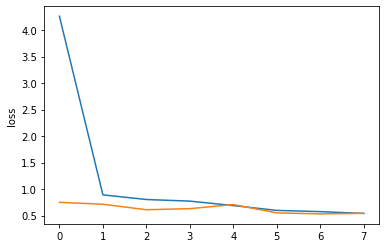

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.lineplot(data = df['loss'])
sns.lineplot(data = df['val_loss'])

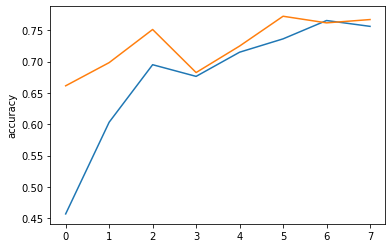

In [31]:
plt.figure()
sns.lineplot(data = df['accuracy'])
sns.lineplot(data = df['val_accuracy'])

In [32]:
from tensorflow.keras.applications import EfficientNetB0
eff_net = EfficientNetB0(weights='imagenet', include_top = False, input_shape = (250,350,3))

16711680/16705208 [==============================] - 0s 0us/step


In [39]:
model = tf.keras.models.Sequential()
model.add(eff_net)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(Dense(3, activation= 'sigmoid'))

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 11, 1280)       4049571   
_________________________________________________________________
flatten_5 (Flatten)          (None, 112640)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               28836096  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 32,886,438
Trainable params: 32,844,415
Non-trainable params: 42,023
_________________________________________________________________


In [44]:
ckpt = ModelCheckpoint('/content/drive/MyDrive/Deep learning model/CNN_amazon2/', 
                       monitor = 'val_accuracy',
                       save_best_only=True)

In [41]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ['accuracy'])

In [45]:
history = model.fit(train_data, epochs = 10,validation_data=test_data, verbose = 2, callbacks = [reduce_lr, stop, ckpt])

Epoch 1/10
47/47 - 24s - loss: 0.1661 - accuracy: 0.9348 - val_loss: 0.1609 - val_accuracy: 0.9312


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep learning model/CNN_amazon2/assets
Epoch 2/10
47/47 - 25s - loss: 0.1847 - accuracy: 0.9294 - val_loss: 0.1579 - val_accuracy: 0.9471


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep learning model/CNN_amazon2/assets
Epoch 3/10
47/47 - 24s - loss: 0.1804 - accuracy: 0.9268 - val_loss: 0.1546 - val_accuracy: 0.9577


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep learning model/CNN_amazon2/assets
Epoch 4/10
47/47 - 24s - loss: 0.1977 - accuracy: 0.9174 - val_loss: 0.2446 - val_accuracy: 0.9365
Epoch 5/10
47/47 - 24s - loss: 0.1983 - accuracy: 0.9174 - val_loss: 0.2329 - val_accuracy: 0.9206
Epoch 6/10
47/47 - 24s - loss: 0.1942 - accuracy: 0.9214 - val_loss: 0.1760 - val_accuracy: 0.9418


In [46]:
model.evaluate(test_data)

12/12 [==============================] - 2s 176ms/step - loss: 0.1760 - accuracy: 0.9418


[0.17603273689746857, 0.9417989253997803]

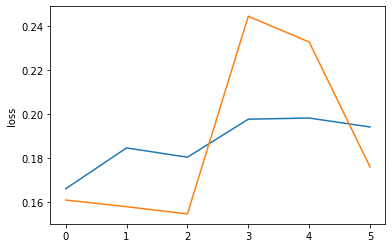

In [47]:
df = pd.DataFrame(history.history)
plt.figure()
sns.lineplot(data = df['loss'])
sns.lineplot(data = df['val_loss'])

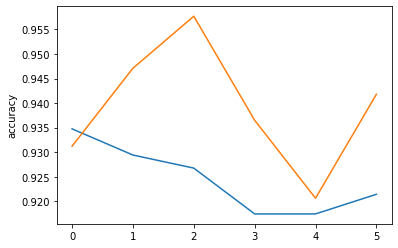

In [55]:
plt.figure()
sns.lineplot(data = df['accuracy'])
sns.lineplot(data = df['val_accuracy'])